In [1]:
import pandas
import vcfpy
from pathlib import Path
from collections import defaultdict
import seaborn
from collections import Counter
import numpy
from matplotlib import pyplot as plt
import scipy
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

seaborn.set_style("whitegrid")

In [2]:
patient = "BH_2"

In [3]:
second_patient_path = Path(f"../data/{patient}/")

In [4]:
allele_frequency_first_time_point = defaultdict(list)
for ts in range(1, 6):
    for repr in [1, 2]:    
        reader = vcfpy.Reader.from_path(second_patient_path / f"ts_{ts}_rep{repr}.vcf")
        
        for record in reader:
            key = (
                record.CHROM,
                record.POS,
                record.REF,
                record.ALT[0].type, 
                record.ALT[0].value,
            )
            allele_frequency_first_time_point[key].append((ts, record.INFO["AF"]))


/home/lev/Projects/biohack/OncoTracker/.venv/lib/python3.10/site-packages/vcfpy/header.py:413: FieldInfoNotFound: INFO SOMATIC not found using Flag/0 instead
  warnings.warn(


In [5]:
time_point_amount = []

In [6]:
for k, v in allele_frequency_first_time_point.items():
    time_point_amount.append(len({tp for tp, _ in v}))

In [7]:
Counter(time_point_amount)

Counter({1: 21814, 2: 951, 3: 211, 4: 46, 5: 34})

In [8]:
not_rear_mut = defaultdict(list)
for k, v in allele_frequency_first_time_point.items():
    
    amount = len({tp for tp, _ in v})
    name = "_".join(map(str, k))
    if amount >= 2:
        not_rear_mut[amount].append(("_".join(map(str, sorted({tp for tp, _ in v}))), name))

In [9]:
with open(f"../data/not_rare_{patient.lower()}.csv", "w") as nr_file:
    for amount in [2, 3, 4, 5]:
        for points, name in not_rear_mut[amount]:
            nr_file.write(f"{amount}, {points}, {name}\n") 

In [10]:
all_mutations_are_presented = dict()
for k, v in allele_frequency_first_time_point.items():
    amount = len({tp for tp, _ in v})
    if amount == 5:
        name = "_".join(map(str, k))
        freqs = [[] for _ in range(5)]
        for idx, freq in v:
            freqs[idx - 1].append(freq)
        all_mutations_are_presented[name] = freqs

In [11]:
ordered_names = list(all_mutations_are_presented.keys())

In [12]:
a_freqs = [[] for _ in range(len(ordered_names))]
for idx, name in enumerate(ordered_names):
    a_freqs[idx] = numpy.array(list(map(numpy.mean, all_mutations_are_presented[name])))

In [13]:
a_freqs = numpy.array(a_freqs)


In [14]:
_min = numpy.min(a_freqs, axis=1)[numpy.newaxis].T
_max = numpy.max(a_freqs, axis=1)[numpy.newaxis].T
a_freqs = (a_freqs - _min) / (_max - _min)

In [15]:
freq_norm_dict = {ordered_names[idx]: freqs for idx, freqs in enumerate(a_freqs)}

In [16]:
d = pandas.DataFrame(data=a_freqs.T, columns=ordered_names)

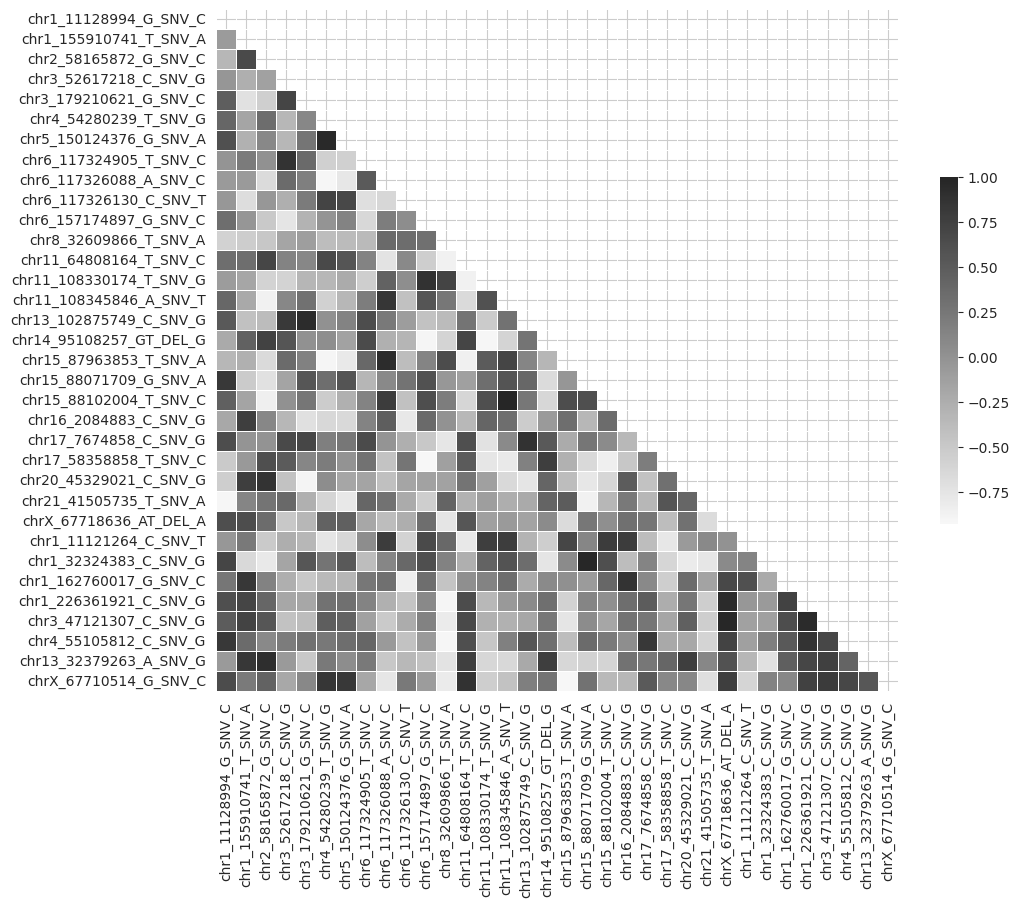

In [17]:
corr = d.corr()
mask = numpy.triu(numpy.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = seaborn.dark_palette("#FFFFFF", as_cmap=True, reverse=True)
seaborn.heatmap(
    corr, 
    mask=mask, 
    cmap=cmap, 
    center=0,
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5},
    vmin=corr.to_numpy().min(), 
    vmax=corr.to_numpy().max(),
)
plt.savefig("../results/bh_2_correlation.pdf", bbox_inches = 'tight')
plt.show()

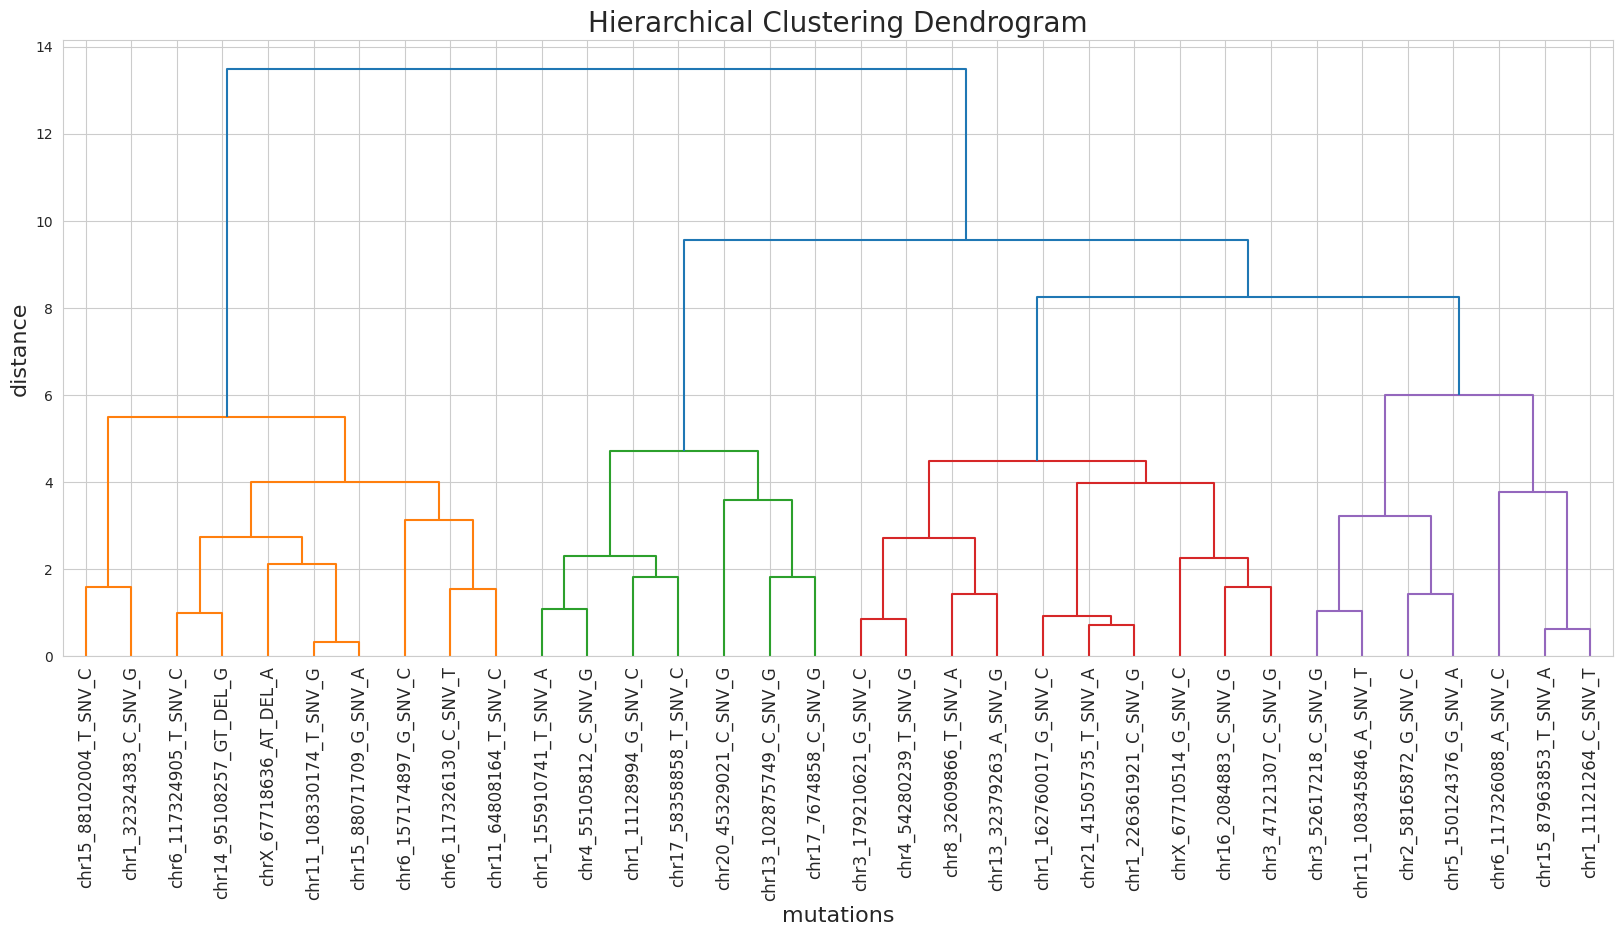

In [18]:
labels = ordered_names
p = len(labels)

plt.figure(figsize=(20,8))
plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
plt.xlabel('mutations', fontsize=16)
plt.ylabel('distance', fontsize=16)

Z = linkage(corr, 'ward')

R = dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=p,  # show only the last p merged 
    no_plot=True,
)

temp = {R["leaves"][i]: labels[R["leaves"][i] - 1] for i in range(len(R["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])

dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged 
    p=p,  # show only the last p merged clusters
    leaf_label_func=llf,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    color_threshold = 6,
)
plt.savefig(f"../results/{patient.lower()}_dendrogram.pdf", bbox_inches = 'tight')
plt.show()

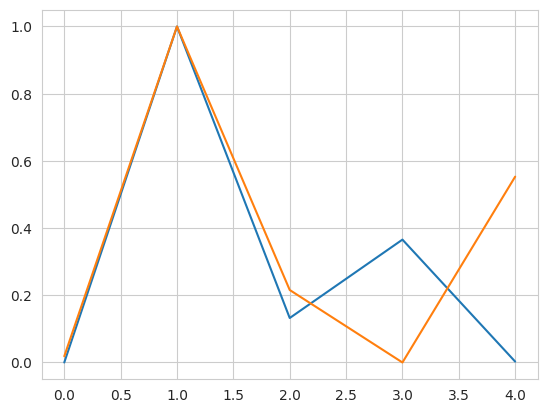

In [19]:
plt.plot(freq_norm_dict["chr15_87963853_T_SNV_A"])
plt.plot(freq_norm_dict["chr1_11121264_C_SNV_T"])

In [20]:
groups = [list(temp.values())[:10], list(temp.values())[10:17], list(temp.values())[17:]]

In [21]:
first_group = {
    "mutation": [],
    "frequency": [],
    "point": [],
}

for name in groups[0]:
    allele_freq_line = list(freq_norm_dict[name])
    first_group["mutation"].extend([name] * len(allele_freq_line))
    first_group["frequency"].extend(allele_freq_line)
    first_group["point"].extend(list(range(1, len(allele_freq_line) + 1)))

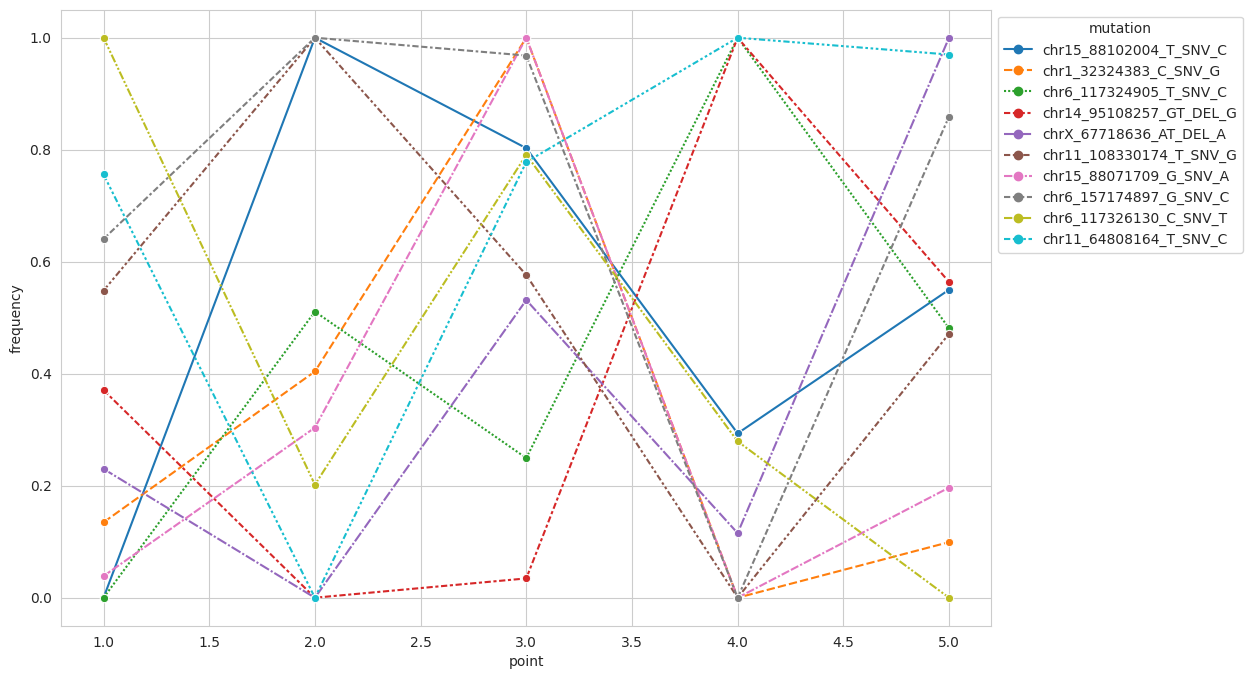

In [22]:
plt.figure(figsize=(12,8))
ax = seaborn.lineplot(
    pandas.DataFrame.from_dict(first_group),
    x="point",
    y="frequency",
    hue="mutation",
    style="mutation",
    markers=["o"] * 10
)
seaborn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [23]:
second_group = {
    "mutation": [],
    "frequency": [],
    "point": [],
}

for name in groups[1]:
    allele_freq_line = list(freq_norm_dict[name])
    second_group["mutation"].extend([name] * len(allele_freq_line))
    second_group["frequency"].extend(allele_freq_line)
    second_group["point"].extend(list(range(1, len(allele_freq_line) + 1)))

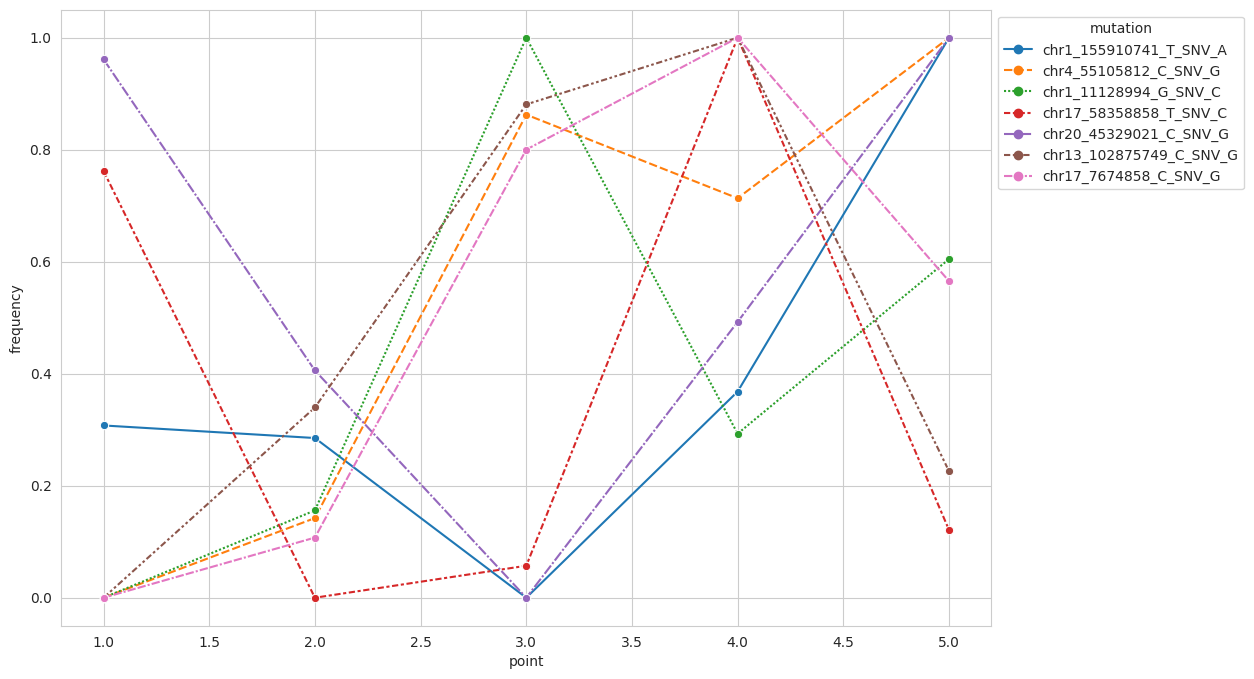

In [24]:
plt.figure(figsize=(12,8))
ax = seaborn.lineplot(
    pandas.DataFrame.from_dict(second_group),
    x="point",
    y="frequency",
    hue="mutation",
    style="mutation",
    markers=["o"] * len(groups[1])
)
seaborn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [25]:
third_group = {
    "mutation": [],
    "frequency": [],
    "point": [],
}

for name in groups[2]:
    allele_freq_line = list(freq_norm_dict[name])
    third_group["mutation"].extend([name] * len(allele_freq_line))
    third_group["frequency"].extend(allele_freq_line)
    third_group["point"].extend(list(range(1, len(allele_freq_line) + 1)))

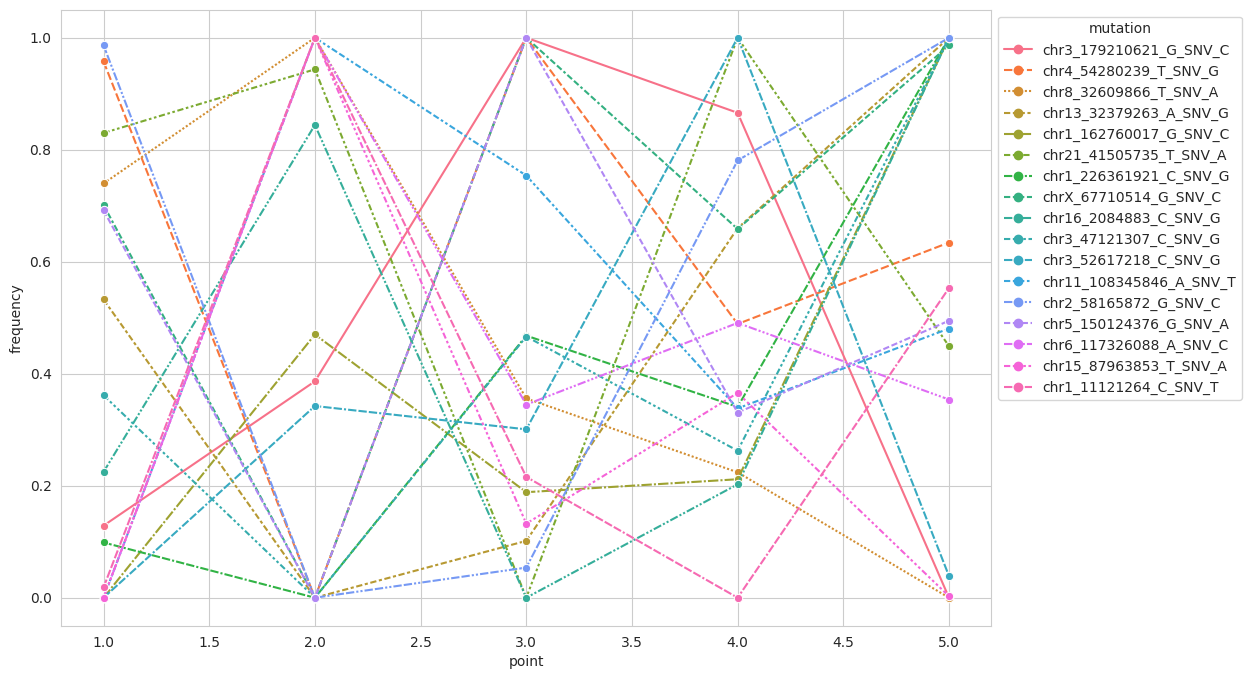

In [26]:
plt.figure(figsize=(12,8))
ax = seaborn.lineplot(
    pandas.DataFrame.from_dict(third_group),
    x="point",
    y="frequency",
    hue="mutation",
    style="mutation",
    markers=["o"] * len(groups[2])
)
seaborn.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

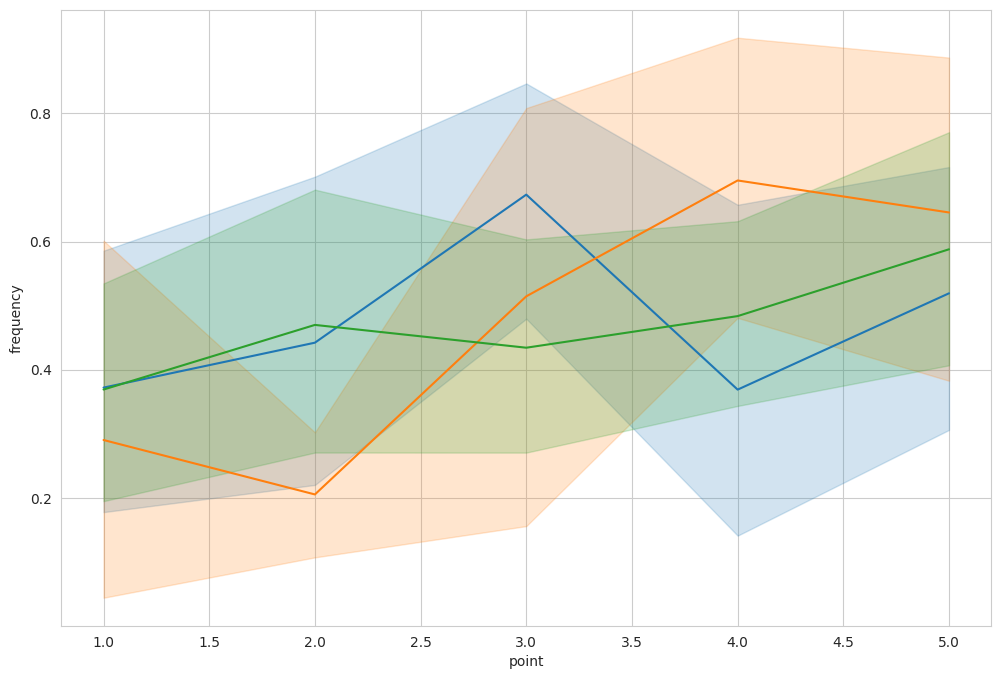

In [27]:
plt.figure(figsize=(12,8))
ax = seaborn.lineplot(
    pandas.DataFrame.from_dict(first_group),
    x="point",
    y="frequency",
)
ax = seaborn.lineplot(
    pandas.DataFrame.from_dict(second_group),
    x="point",
    y="frequency",
)
ax = seaborn.lineplot(
    pandas.DataFrame.from_dict(third_group),
    x="point",
    y="frequency",
)